## HW3. Настройка окружения для работы с Ansible

### Автор: *Кузнецов Кирилл Игоревич*
### Группа: М08-401НД
### Дата: 01.11.2025

Это задание выполняется в рамках модуля 3 «Инфраструктура как код, Ansible и Terraform». 

In [ ]:
%%capture
!sudo apt update
!sudo apt install -y ansible
!pip install ansible -qqq

### Настройка окружения для работы с OpenTofu



In [ ]:
# !curl --proto '=https' --tlsv1.2 -fsSL https://get.opentofu.org/install-opentofu.sh -o install-opentofu.sh
# !chmod +x install-opentofu.sh
# !./install-opentofu.sh --install-method deb
# !rm -f install-opentofu.sh

OpenTofu Installer

Attempting installation via Debian repository...
Updating package list...
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 https://cli.github.com/packages stable InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubu

In [ ]:
# В моем случае 
# brew install opentofu
# sudo chmod +x /opt/homebrew/bin/tofu
# brew install ansible

In [1]:
!which tofu

/opt/homebrew/bin/tofu


In [2]:
!tofu version

OpenTofu v1.10.6
on darwin_arm64
+ provider registry.opentofu.org/hashicorp/null v3.2.4


Ansible поможет нам управлять инфраструктурой, а OpenTofu будет использоваться для описания и развертывания ресурсов.

In [3]:
%%writefile inventory.ini
[local]
localhost ansible_connection=local

Overwriting inventory.ini


In [4]:
%%writefile playbook.yaml
---
- name: Создаём инфраструктуру с OpenTofu
  hosts: local
  tasks:
    - name: Создать новый проект с OpenTofu
      command: tofu init

    - name: Посмотреть конфиг OpenTofu
      command: tofu show


Overwriting playbook.yaml


Выполним плейбук

In [5]:
!ansible-playbook -i inventory.ini playbook.yaml


PLAY [Создаём инфраструктуру с OpenTofu] ***************************************

TASK [Gathering Facts] *********************************************************
[WARNING]: Host 'localhost' is using the discovered Python interpreter at '/opt/homebrew/bin/python3.13', but future installation of another Python interpreter could cause a different interpreter to be discovered. See https://docs.ansible.com/ansible-core/2.19/reference_appendices/interpreter_discovery.html for more information.
ok: [localhost]

TASK [Создать новый проект с OpenTofu] *****************************************
changed: [localhost]

TASK [Посмотреть конфиг OpenTofu] **********************************************
changed: [localhost]

PLAY RECAP *********************************************************************
localhost                  : ok=3    changed=2    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   



In [6]:
!tofu show

No state.


___
## Задание 1. Отладка конфигурации Ansible

Задача: в конфигурации Ansible нет файла инвентаря. Нужно прописать файл инвентаря, чтобы плейбук выполнялся корректно.


In [7]:
%%writefile inventory.ini
[local]
localhost ansible_connection=local

Overwriting inventory.ini


In [8]:
%%writefile playbook.yaml
---
- name: Установка и запуск веб-сервера
  hosts: local
  become: no
  tasks:
    - name: Установка Apache
      homebrew:
        name: httpd
        state: present
    - name: Запуск и включение Apache
      command: brew services start httpd

Overwriting playbook.yaml


Более простая реализация, установка пакета тоже через команду (проверил и то и то работает)

In [9]:
%%writefile playbook.yaml
---
- name: Установка и запуск веб-сервера
  hosts: local
  become: no
  tasks:
    - name: Установка Apache
      command: brew install httpd
    - name: Запуск и включение Apache
      command: brew services start httpd

Overwriting playbook.yaml


### Исправление ошибок в плейбуке

1. Убедитесь, что Ansible установлен и доступен для выполнения команд.
2. Проверьте, что файл инвентаря и плейбук созданы корректно.
3. Запустите плейбук и исправьте ошибки, если они возникнут.

При корректном запуске в итоговой строке PLAY RECAP будет указано количество выполненных без ошибок этапов ok=3

---
# Исправления: 
1. замена hosts: local
2. become: no -> для отмены запроса пароля на локалхосте
3. замена apt -> homebrew и замена названия пакета
4. убрал update_cache: yes ибо конфликт
5. заменил
      service:
        name: httpd
        state: started
        enabled: yes

    на 
      command: brew services start httpd - консольную команду

In [10]:
!ansible-playbook -i inventory.ini playbook.yaml # Выполняем плейбук для установки и запуска Apache


PLAY [Установка и запуск веб-сервера] ******************************************

TASK [Gathering Facts] *********************************************************
[WARNING]: Host 'localhost' is using the discovered Python interpreter at '/opt/homebrew/bin/python3.13', but future installation of another Python interpreter could cause a different interpreter to be discovered. See https://docs.ansible.com/ansible-core/2.19/reference_appendices/interpreter_discovery.html for more information.
ok: [localhost]

TASK [Установка Apache] ********************************************************
changed: [localhost]

TASK [Запуск и включение Apache] ***********************************************
changed: [localhost]

PLAY RECAP *********************************************************************
localhost                  : ok=3    changed=2    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   



> Пришлось немного адаптировать плэйбук под запуск на локальном макбуке, в частности поменял имя хоста (судя по всему это была прямая ошибка), потом убрал флаг bekome:yes отключив проверку пароля (решил не вывоидть его в секреты), ну и адаптация для запуска с моим пакетным менеджером

---
## Задание 2. Отладка конфигурации OpenTofu

Задача: конфигурация OpenTofu содержит опечатку. Исправьте ошибку, чтобы конфигурация проходила валидацию.

In [11]:
%%writefile main.tf
terraform {
  required_providers {
    null = {
      source = "hashicorp/null"
      version = ">= 3.0"
    }
  }
}

data "null_data_source" "example" {
  inputs = {
    location = "ru-1"
    disk = 18 * 1024
    type = "postgres"                # <- как нужно правильно оформить строковый лиерал ? отввет - закрыть кавычки
  }
}

resource "null_resource" "example" {
  provisioner "local-exec" {
    command = "echo 'Создан требуемый ресурс'"
  }
}

Overwriting main.tf


# Исправления
1. Закрыл кавычки type = "postgres" 
2. Включил VPN без него 403 ответ, что как бы сразу намекнуло, что это будет самым простым решением..

In [12]:
!tofu init


Initializing the backend...

Initializing provider plugins...
- Reusing previous version of hashicorp/null from the dependency lock file
- Using previously-installed hashicorp/null v3.2.4

OpenTofu has been successfully initialized!

You may now begin working with OpenTofu. Try running "tofu plan" to see
any changes that are required for your infrastructure. All OpenTofu commands
should now work.

If you ever set or change modules or backend configuration for OpenTofu,
rerun this command to reinitialize your working directory. If you forget, other
commands will detect it and remind you to do so if necessary.


### Исправление ошибок в конфигурации OpenTofu

1. Убедитесь, что OpenTofu установлен и доступен для выполнения команд.
2. Проверьте корректность конфигурационного файла.

Валидация успешна, если есть сообщение `Success!` The configuration is valid, but there were some validation warnings as shown above.



## Использование логов и отладочных инструментов

Логи и отладочные инструменты помогают глубже понять, что происходит в процессе выполнения команд Ansible и OpenTofu. Используйте их для выявления и устранения проблем.

In [13]:
# Включение детализированных логов для Ansible
!ansible-playbook -i inventory.ini playbook.yaml -v # Запускаем плейбук с детализированными логами

No config file found; using defaults

PLAY [Установка и запуск веб-сервера] ******************************************

TASK [Gathering Facts] *********************************************************
[WARNING]: Host 'localhost' is using the discovered Python interpreter at '/opt/homebrew/bin/python3.13', but future installation of another Python interpreter could cause a different interpreter to be discovered. See https://docs.ansible.com/ansible-core/2.19/reference_appendices/interpreter_discovery.html for more information.
ok: [localhost]

TASK [Установка Apache] ********************************************************
changed: [localhost] => {"changed": true, "cmd": ["brew", "install", "httpd"], "delta": "0:00:01.317324", "end": "2025-10-30 15:34:21.683041", "msg": "", "rc": 0, "start": "2025-10-30 15:34:20.365717", "stderr": "Warning: httpd 2.4.65 is already installed and up-to-date.\nTo reinstall 2.4.65, run:\n  brew reinstall httpd", "stderr_lines": ["Warning: httpd 2.4.65 is al

In [14]:
!export TOFU_LOG=DEBUG # Устанавливаем уровень логирования на DEBUG для OpenTofu
!tofu validate

╷
│ Warning: Deprecated
│ 
│   with data.null_data_source.example,
│   on main.tf line 10, in data "null_data_source" "example":
│   10: data "null_data_source" "example" {
│ 
│ The null_data_source was historically used to construct intermediate values
│ to re-use elsewhere in configuration, the same can now be achieved using
│ locals or the terraform_data resource type in Terraform 1.4 and later.
╵
Success! The configuration is valid, but there were some
validation warnings as shown above.


> Валидация пройдена но есть предупреждение об устаревшем компоненте: "data "null_data_source" "example"" отладчик предлагает использовать "locals", попробуем

In [15]:
%%writefile main.tf
terraform {
  required_providers {
    null = {
      source = "hashicorp/null"
      version = ">= 3.0"
    }
  }
}

locals {
  inputs = {
    location = "ru-1"
    disk = 18 * 1024
    type = "postgres"                # <- как нужно правильно оформить строковый лиерал ? отввет - закрыть кавычки
  }
}

resource "null_resource" "example" {
  provisioner "local-exec" {
    command = "echo 'Создан требуемый ресурс'"
  }
}



Overwriting main.tf


In [16]:
!tofu init


Initializing the backend...

Initializing provider plugins...
- Reusing previous version of hashicorp/null from the dependency lock file
- Using previously-installed hashicorp/null v3.2.4

OpenTofu has been successfully initialized!

You may now begin working with OpenTofu. Try running "tofu plan" to see
any changes that are required for your infrastructure. All OpenTofu commands
should now work.

If you ever set or change modules or backend configuration for OpenTofu,
rerun this command to reinitialize your working directory. If you forget, other
commands will detect it and remind you to do so if necessary.


In [17]:
# Включение детализированных логов для Ansible
!ansible-playbook -i inventory.ini playbook.yaml -v # Запускаем плейбук с детализированными логами

No config file found; using defaults

PLAY [Установка и запуск веб-сервера] ******************************************

TASK [Gathering Facts] *********************************************************
[WARNING]: Host 'localhost' is using the discovered Python interpreter at '/opt/homebrew/bin/python3.13', but future installation of another Python interpreter could cause a different interpreter to be discovered. See https://docs.ansible.com/ansible-core/2.19/reference_appendices/interpreter_discovery.html for more information.
ok: [localhost]

TASK [Установка Apache] ********************************************************
changed: [localhost] => {"changed": true, "cmd": ["brew", "install", "httpd"], "delta": "0:00:01.175464", "end": "2025-10-30 15:34:33.144996", "msg": "", "rc": 0, "start": "2025-10-30 15:34:31.969532", "stderr": "Warning: httpd 2.4.65 is already installed and up-to-date.\nTo reinstall 2.4.65, run:\n  brew reinstall httpd", "stderr_lines": ["Warning: httpd 2.4.65 is al

In [18]:
!export TOFU_LOG=DEBUG # Устанавливаем уровень логирования на DEBUG для OpenTofu
!tofu validate

Success! The configuration is valid.


> Теперь все хорошо. Ансибл отрабатывает как нужно, валидация на тофу проходит без ворнингов.

___
## Задание 3. Работа с оберткой Tofupy

Задачи:
1. Подключить библиотеку-обертку Tofupy через import.
2. Указать рабочую директорию, путь до бинарного файла.
3. Вызвать метод workspace.validate для проверки конфигурации на наличие ошибок.

- Если в конфигурации есть ошибка, то будет сообщение «Конфигурация некорректна».
- Если нет ошибок, то будет сообщение «Конфигурация некорректна».


In [66]:
!pip install tofupy -qq
!mkdir tofudir

In [19]:
import os
from tofupy import Tofu

workspace = Tofu(cwd="./tofudir",     # Указываем рабочую директорию
    binary="tofu",                    # Указываем бинарный файл OpenTofu
    log_level="DEBUG",
    env={"TF_VAR_environment": "production"} #
)
workspace.init()

# ВАШ КОД ЗДЕСЬ
validation = workspace.validate()  # <-собственно вот
# ВАШ КОД ЗДЕСЬ

if not validation.valid:
    print("конфигурация некорректна!")
    for diagnostic in validation.diagnostics:
        print(f"ошибки конфигурации: {diagnostic.summary}")
else:
    print("конфигурация корректна!")



конфигурация корректна!


> Обертка tofu позволяет пройти валидцию используя единственный метод, который возвраает True или False, что обеспечивает простоту в построении кодовой логики

___
## Задание 4. Программное создание бакета S3

Задача: на языке HCL (Terraform/Tofu) описать холодное хранилище на 20 Гб, используя S3.

Чтобы на языке HCL (Terraform/Tofu) описать холодное хранилище на 20 Гб, используя S3, нужно указать disk = 20 * 1024

Формат описания приведен в конспекте занятия.

Дополнение от выполняющего:
В Yandex Cloud S3 хранилище имеет динамический размер, адаптируясь к потребностям автоматически, следовательно указывать размер негде.


---
## Ход предподготовки  подключения к провайдеру Yandex Cloud

### 1. Подключился к yandex cloud (yandex cloud cli был установлен), создал ресурс и сервисный аккаунт terraform-sa (с правами админа)

### 2. Установил terraform через 

`brew install terraform`

## Подключение tf к YC

Нижеследующие пункты делал по гайду Яндекса:

### 1. Создал и заполнил .terraformrc для провайдера яндекс клауд:

```bash
cat > ~/.terraformrc << 'EOF'
provider_installation {
  network_mirror {
    url = "https://terraform-mirror.yandexcloud.net/"
    include = ["registry.terraform.io/*/*"]
  }
  direct {
    exclude = ["registry.terraform.io/*/*"]
  }
}
EOF
```
Так же добавил folder_id

### 2. Создал папку для проекта
```bash
mkdir ~/yandex-terraform
cd ~/yandex-terraform
```

### 3. Создал основной конфигурационный файл
```bash
touch main.tf
```


### 4. В начале конфигурационного файла .tf добавил следующие блоки:

```json
terraform {
  required_providers {
    yandex = {
      source = "yandex-cloud/yandex"
    }
  }
  required_version = ">= 0.13"
}

provider "yandex" {
  zone = "<зона_доступности_по_умолчанию>"
}
```

### 5. Выполнил команду `terraform init` в папке с конфигурационным файлом

### Вывод консоли:

```bash
Initializing the backend...

Initializing provider plugins...
- Reusing previous version of yandex-cloud/yandex from the dependency lock file
- Using previously-installed yandex-cloud/yandex v0.169.0

Terraform has been successfully initialized!

You may now begin working with Terraform. Try running "terraform plan" to see
any changes that are required for your infrastructure. All Terraform commands
should now work.

If you ever set or change modules or backend configuration for Terraform,
rerun this command to reinitialize your working directory. If you forget, other
commands will detect it and remind you to do so if necessary.

```



In [2]:
# Использование сервисного аккаунта terraform-sa
'''
resource "yandex_storage_bucket" "my-bucket" {
  bucket     = "my-terraform-bucket"
  access_key = yandex_iam_service_account_static_access_key.sa-key.access_key
  secret_key = yandex_iam_service_account_static_access_key.sa-key.secret_key
}

'''

# Создание статических ключей для сервисного аккаунта
'''
resource "yandex_iam_service_account_static_access_key" "sa-key" {
  service_account_id = yandex_iam_service_account.terraform-sa.id
  description        = "Static access key for Object Storage"
}
'''

# Данные существующего сервисного аккаунта
'''
data "yandex_iam_service_account" "terraform-sa" {
  name = "terraform-sa"
}
'''

'\ndata "yandex_iam_service_account" "terraform-sa" {\n  name = "terraform-sa"\n}\n'

### Обновляем итоговый main.tf

In [23]:
%%writefile main.tf
terraform {
  required_providers {
    yandex = {
      source = "yandex-cloud/yandex"
    }
  }
}

# Прячем креденшелсы
variable "yc_folder_id" {
  description = "Yandex Cloud Folder ID"
  type        = string
  sensitive   = true
}

variable "yc_token" {
  description = "Yandex Cloud OAuth token"
  type        = string
  sensitive   = true
}

# Указываем провайдера
provider "yandex" {
  zone      = "ru-central1-a"
  folder_id = var.yc_folder_id
  token     = var.yc_token
}

resource "yandex_iam_service_account" "terraform-sa" {
  name        = "terraform-sa-tf"
  description = "Service account for Terraform"
  folder_id   = var.yc_folder_id
}

# Даем права на папку
resource "yandex_resourcemanager_folder_iam_member" "editor" {
  folder_id = var.yc_folder_id
  role      = "editor"
  member    = "serviceAccount:${yandex_iam_service_account.terraform-sa.id}"
}

# Создаем статические ключи
resource "yandex_iam_service_account_static_access_key" "sa-key" {
  service_account_id = yandex_iam_service_account.terraform-sa.id
  description        = "Static access key for Object Storage"
}

# Создаем бакет
resource "yandex_storage_bucket" "my-bucket" {
  bucket     = "my-terraform-bucket-${yandex_iam_service_account.terraform-sa.id}"
  access_key = yandex_iam_service_account_static_access_key.sa-key.access_key
  secret_key = yandex_iam_service_account_static_access_key.sa-key.secret_key
}


Overwriting main.tf


### Проверяем план

In [24]:
!terraform plan


Terraform used the selected providers to generate the following execution plan.
Resource actions are indicated with the following symbols:
  + create

Terraform will perform the following actions:

  # yandex_iam_service_account.terraform-sa will be created
  + resource "yandex_iam_service_account" "terraform-sa" {
      + created_at         = (known after apply)
      + description        = "Service account for Terraform"
      + folder_id          = (sensitive value)
      + id                 = (known after apply)
      + name               = "terraform-sa-tf"
      + service_account_id = (known after apply)
    }

  # yandex_iam_service_account_static_access_key.sa-key will be created
  + resource "yandex_iam_service_account_static_access_key" "sa-key" {
      + access_key                   = (known after apply)
      + created_at                   = (known after apply)
      + description                  = "Static access key for Object Storage"
      + encrypted_secret_key      

> Валидация действий - успешна

### Реинициализируем

In [25]:
!terraform init


Initializing the backend...

Initializing provider plugins...
- Reusing previous version of yandex-cloud/yandex from the dependency lock file
- Using previously-installed yandex-cloud/yandex v0.169.0

Terraform has been successfully initialized!

You may now begin working with Terraform. Try running "terraform plan" to see
any changes that are required for your infrastructure. All Terraform commands
should now work.

If you ever set or change modules or backend configuration for Terraform,
rerun this command to reinitialize your working directory. If you forget, other
commands will detect it and remind you to do so if necessary.


### Применяем внесенные правки, создавая бакет (прим.: указал автоапрув тк в ноутбуке не появлялось строки активного ввода, хотя раньше вроде была)

In [29]:
!terraform apply -auto-approve


Terraform used the selected providers to generate the following execution plan.
Resource actions are indicated with the following symbols:
  + create

Terraform will perform the following actions:

  # yandex_iam_service_account.terraform-sa will be created
  + resource "yandex_iam_service_account" "terraform-sa" {
      + created_at         = (known after apply)
      + description        = "Service account for Terraform"
      + folder_id          = (sensitive value)
      + id                 = (known after apply)
      + name               = "terraform-sa-tf"
      + service_account_id = (known after apply)
    }

  # yandex_iam_service_account_static_access_key.sa-key will be created
  + resource "yandex_iam_service_account_static_access_key" "sa-key" {
      + access_key                   = (known after apply)
      + created_at                   = (known after apply)
      + description                  = "Static access key for Object Storage"
      + encrypted_secret_key      

> Все прошло корректно. После всего проделанного добавил все связанное с tf в гитигнор для избежания утечки ключей.

### Скриншот из облака

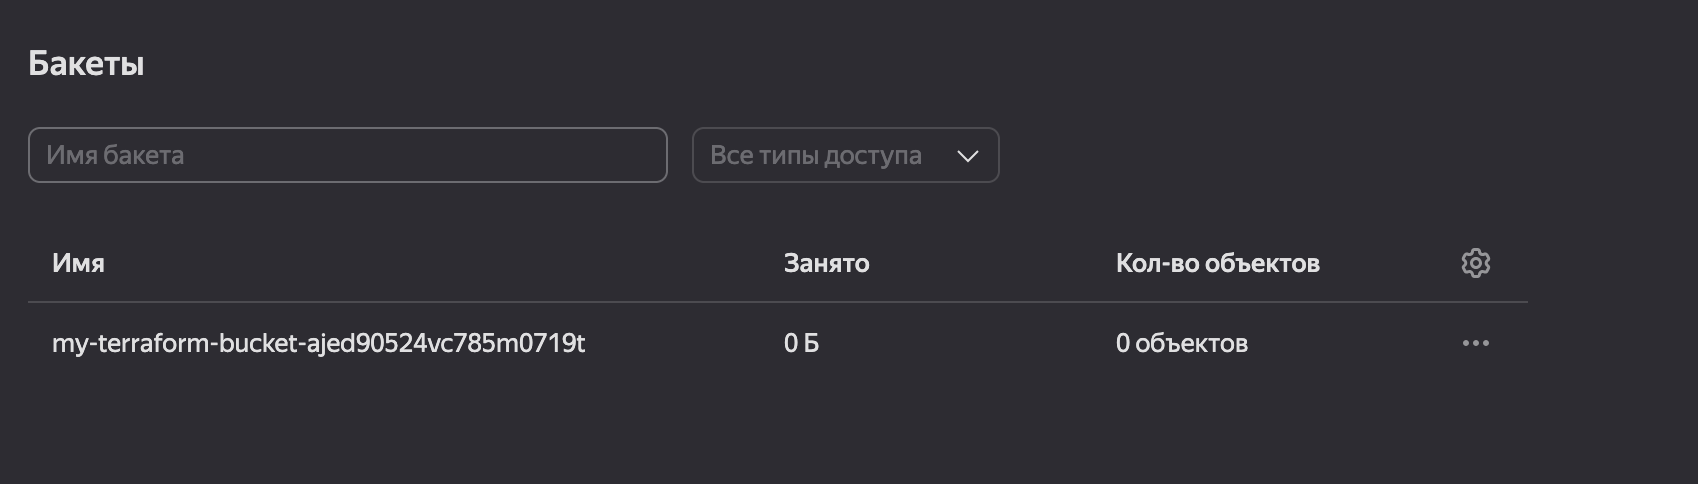

___
## Задание 5. Программное создание базы данных

Задача: создайте пресет базы PostgreSQL с диском на 80 ГБ и экземпляр  базы PostgreSQL с логином/паролем user_010101/888-fff-888 на языке HCL.

Чтобы на языке HCL (Terraform/Tofu) описать базу PostgreSQL с диском на 80 ГБ,  нужно указать:
* disk = 80 * 1024
* login = " user_010101"
* password = "888-fff-888”.

Формат описания приведен в конспекте занятия.


### Переиспользуем main.tf из прошлого задания, немного его модифицировав

In [32]:
%%writefile main.tf

terraform {
  required_providers {
    yandex = {
      source = "yandex-cloud/yandex"
    }
  }
}

variable "yc_folder_id" {
  description = "Yandex Cloud Folder ID"
  type        = string
  sensitive   = true
}

variable "yc_token" {
  description = "Yandex Cloud OAuth token"
  type        = string
  sensitive   = true
}

provider "yandex" {
  zone      = "ru-central1-a"
  folder_id = var.yc_folder_id
  token     = var.yc_token
}

# Создаем сеть для базы данных
resource "yandex_vpc_network" "db-network" {
  name = "db-network"
}

# Создаем подсеть
resource "yandex_vpc_subnet" "db-subnet" {
  name           = "db-subnet"
  zone           = "ru-central1-a"
  network_id     = yandex_vpc_network.db-network.id
  v4_cidr_blocks = ["10.1.0.0/24"]
}

# Кластер PostgreSQL
resource "yandex_mdb_postgresql_cluster" "postgres-db" {
  name        = "postgres-cluster"
  environment = "PRODUCTION"
  network_id  = yandex_vpc_network.db-network.id

  config {
    version = 15  # Версия PostgreSQL
    resources {
      resource_preset_id = "s2.micro"  # Конфигурация CPU/RAM
      disk_type_id       = "network-ssd"
      disk_size          = 80 * 1024   # 80 ГБ в МБ
    }
  }

  host {
    zone      = "ru-central1-a"
    subnet_id = yandex_vpc_subnet.db-subnet.id
  }
}

# База данных в кластере
resource "yandex_mdb_postgresql_database" "db" {
  cluster_id = yandex_mdb_postgresql_cluster.postgres-db.id
  name       = "my_database"
  owner      = "user_010101"
}

# Пользователь базы данных
resource "yandex_mdb_postgresql_user" "db_user" {
  cluster_id = yandex_mdb_postgresql_cluster.postgres-db.id
  name       = "user_010101"
  password   = "888-fff-888"
}

resource "yandex_iam_service_account" "terraform-sa" {
  name        = "terraform-sa-tf"
  description = "Service account for Terraform"
  folder_id   = var.yc_folder_id
}

resource "yandex_resourcemanager_folder_iam_member" "editor" {
  folder_id = var.yc_folder_id
  role      = "editor"
  member    = "serviceAccount:${yandex_iam_service_account.terraform-sa.id}"
}

resource "yandex_iam_service_account_static_access_key" "sa-key" {
  service_account_id = yandex_iam_service_account.terraform-sa.id
  description        = "Static access key for Object Storage"
}

resource "yandex_storage_bucket" "my-bucket" {
  bucket     = "my-terraform-bucket-${yandex_iam_service_account.terraform-sa.id}"
  access_key = yandex_iam_service_account_static_access_key.sa-key.access_key
  secret_key = yandex_iam_service_account_static_access_key.sa-key.secret_key
}

Overwriting main.tf


> Создали сеть, бд и пользователя, при этом сохранив бакет

In [33]:
!terraform plan

yandex_iam_service_account.terraform-sa: Refreshing state... [id=ajed90524vc785m0719t]
yandex_resourcemanager_folder_iam_member.editor: Refreshing state...
yandex_iam_service_account_static_access_key.sa-key: Refreshing state... [id=ajejj1a0u272argk2adm]
yandex_storage_bucket.my-bucket: Refreshing state... [id=my-terraform-bucket-ajed90524vc785m0719t]

Terraform used the selected providers to generate the following execution plan.
Resource actions are indicated with the following symbols:
  + create

Terraform will perform the following actions:

  # yandex_mdb_postgresql_cluster.postgres-db will be created
  + resource "yandex_mdb_postgresql_cluster" "postgres-db" {
      + created_at             = (known after apply)
      + deletion_protection    = (known after apply)
      + disk_encryption_key_id = (known after apply)
      + environment            = "PRODUCTION"
      + folder_id              = (known after apply)
      + health                 = (known after apply)
      + host_

> Можно сказать что валидация пройдена (создавать не буду ибо 130 рублей на счете может не хватить)

### Удаляем ресурсы что бы избежать затрат

In [34]:
!terraform destroy -auto-approve

yandex_iam_service_account.terraform-sa: Refreshing state... [id=ajed90524vc785m0719t]
yandex_resourcemanager_folder_iam_member.editor: Refreshing state...
yandex_iam_service_account_static_access_key.sa-key: Refreshing state... [id=ajejj1a0u272argk2adm]
yandex_storage_bucket.my-bucket: Refreshing state... [id=my-terraform-bucket-ajed90524vc785m0719t]

Terraform used the selected providers to generate the following execution plan.
Resource actions are indicated with the following symbols:
  - destroy

Terraform will perform the following actions:

  # yandex_iam_service_account.terraform-sa will be destroyed
  - resource "yandex_iam_service_account" "terraform-sa" {
      - created_at         = "2025-10-31T09:04:43Z" -> null
      - description        = "Service account for Terraform" -> null
      - folder_id          = (sensitive value) -> null
      - id                 = "ajed90524vc785m0719t" -> null
      - name               = "terraform-sa-tf" -> null
      - service_account_id

> Удаление прошло успешно!

___
## Задание 6. Итоговое оформление

Подготовьте ноутбук в логичной структуре:
- написание кода;
- запуск кода;
- текстовые пояснения к шагам (в markdown-ячейках, 5–8 предложений на каждый раздел);
- общий вывод.

В итоговых выводах дайте 5–8 предложений о своем опыте работы с инструментами модуля: что оказалось простым, что вызвало трудности, какие выводы сделали о применимости подхода IaC в реальных проектах.

---
## Итоговые вывод:

### Были протестированы и опробованы инструменты ansible и terraform(+tofu).
В целом можно сказать что оба инструмента оставили положительное впечатление от их использование, но требуют явного углубления в плане их изучения. Ансибл выглядит как удобное решение для работы по разворачиванию инфраструктуры на ограниченном количестве хостов (условно до 100) обладая простым синтаксисом yaml файлов плэйбуков и ini инвентори (инвентои в yaml выглядит ужасно сложно) и применимостью на подавляющем большинстве хост машин, т.к. использует встроенный набор инструментов. Терраформ же выглядит как более разумное решение при взаимодействии с облачными провайдерами, когда инфраструктура раскидывается на тысячии машин, показалось что в этом плане он лучше ansible. При этом синтаксис составления main.tf несравнимо сложнее чем playbooks (на мой взгляд), помимо этого сильной стороной терраформ (и тофу) является возможность взаимодействия через tofupy, что открывает еще большие горизонты по автоматизации.

### Совсем общие выводы:
- Ansible проще начать использовать - достаточно знать базовый YAML и SSH. 
- Terraform требует понимания облачных API, систем типов и управления состоянием.
- Ansible лучше подходит для управления конфигурацией существующих серверов, тогда как Terraform - для создания и управления облачными ресурсами. 
- Tofu с поддержкой Python открывает дополнительные возможности для сложной логики.
- Подход IaC доказал свою эффективность - инфраструктура становится воспроизводимой, версионируемой и документированной.
